# Node2Vec

In [2]:
import pandas as pd
import numpy as np
import random
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx
import networkx as nx
from tqdm import tqdm
from sklearn.decomposition import PCA
# from node2vec import Node2Vec
import matplotlib.pyplot as plt
import warnings
import os

In [18]:
device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
print('Using device:', device)
warnings.filterwarnings('ignore')
data_path = os.environ.get('DATA_PATH') + 'AI_Cheats/'
plt.style.use('default')

Using device: cpu


In [ ]:
# 数据加载，构造图

G = nx.read_gml(data_path + 'football/football.gml')
print(type(G), len(G))

# 将 networkx 图转换成 PyG 的 edge_index
pyg_data = from_networkx(G)  # 包含 edge_index
edge_index = pyg_data.edge_index
num_nodes = G.number_of_nodes()
print(f'num_nodes={num_nodes}, edge_index shape={edge_index.shape}')


<class 'networkx.classes.graph.Graph'> 115
num_nodes=115, edge_index shape=torch.Size([2, 1226])


In [ ]:
# 初始化 Node2Vec 模型

node2vec = Node2Vec(
    edge_index,
    embedding_dim=100,
    walk_length=10,
    context_size=4,  # 对应 window size
    walks_per_node=5,
    p=0.1,
    q=5,
    num_negative_samples=1,
    sparse=True
).to(device)

In [ ]:
# 训练模型

loader = node2vec.loader(batch_size=32, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 21):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 1, Loss: 7.8971
Epoch 2, Loss: 7.0899
Epoch 3, Loss: 6.4399
Epoch 4, Loss: 6.0035
Epoch 5, Loss: 5.3585
Epoch 6, Loss: 5.0972
Epoch 7, Loss: 4.8664
Epoch 8, Loss: 4.5329
Epoch 9, Loss: 4.3225
Epoch 10, Loss: 4.1325
Epoch 11, Loss: 4.0725
Epoch 12, Loss: 3.8459
Epoch 13, Loss: 3.7722
Epoch 14, Loss: 3.4388
Epoch 15, Loss: 3.5327
Epoch 16, Loss: 3.4033
Epoch 17, Loss: 3.3880
Epoch 18, Loss: 3.3315
Epoch 19, Loss: 3.1159
Epoch 20, Loss: 3.0272


In [ ]:
# 获取节点 embedding

node2vec.eval()
with torch.no_grad():
    embeddings = node2vec.embedding.weight.cpu()  # shape: [num_nodes, 100]

# 将 embedding 转换成字典，key 为节点名称
node_name_to_index = {name: i for i, name in enumerate(G.nodes())}
index_to_node_name = {i: name for i, name in enumerate(G.nodes())}

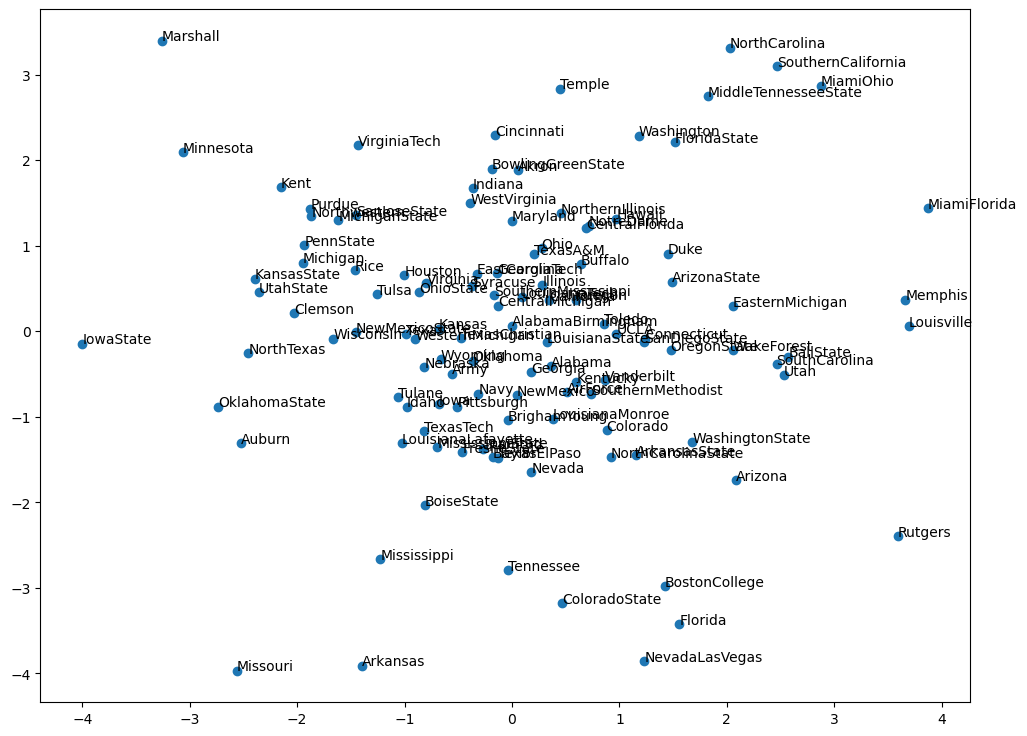

In [ ]:
# 可视化 embedding

def plot_nodes(word_list):
    X = []
    for item in word_list:
        idx = node_name_to_index[item]
        X.append(embeddings[idx].detach().cpu().numpy())  # detach 后再转 numpy
    X = np.array(X)
    
    # PCA 降到 2 维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    # 绘图
    plt.figure(figsize=(12, 9))
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()


# 绘制所有节点
plot_nodes(list(G.nodes()))

In [2]:
# warnings.filterwarnings('ignore')

In [23]:
import torch.nn.functional as F
from torch_geometric.utils import from_networkx

In [ ]:
# 数据加载

data = from_networkx(G)
edge_index = data.edge_index

In [27]:
# 初始化 Node2Vec 模型
node2vec = Node2Vec(
    edge_index,
    embedding_dim=100,
    walk_length=10,
    context_size=4,  # 对应 window size
    walks_per_node=5,
    p=0.25,
    q=5,
    num_negative_samples=1,
    sparse=True
).to(device)

In [28]:
# 训练模型

oader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 21):  # 迭代20轮
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 1, Loss: 7.4192
Epoch 2, Loss: 7.1169
Epoch 3, Loss: 6.3977
Epoch 4, Loss: 5.7352
Epoch 5, Loss: 5.5057
Epoch 6, Loss: 4.9876
Epoch 7, Loss: 4.7268
Epoch 8, Loss: 4.4357
Epoch 9, Loss: 4.2578
Epoch 10, Loss: 4.1882
Epoch 11, Loss: 3.9208
Epoch 12, Loss: 3.7975
Epoch 13, Loss: 3.6443
Epoch 14, Loss: 3.4266
Epoch 15, Loss: 3.4685
Epoch 16, Loss: 3.2801
Epoch 17, Loss: 3.3520
Epoch 18, Loss: 3.1515
Epoch 19, Loss: 3.0940
Epoch 20, Loss: 3.0208


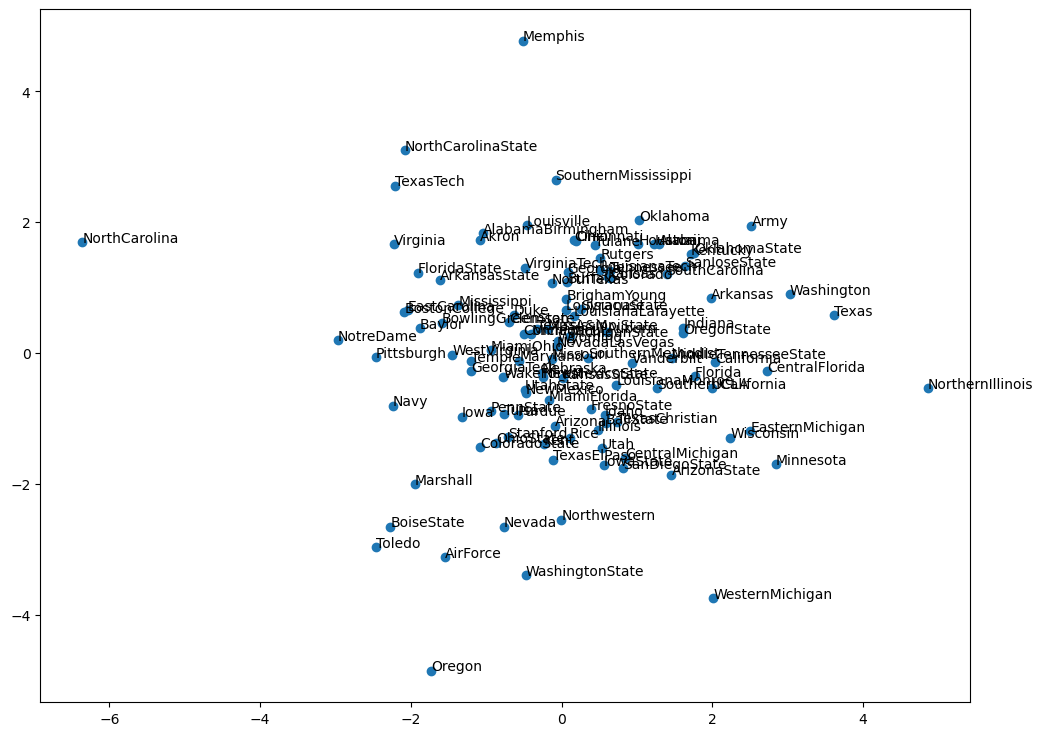

In [29]:
# 获取 embedding

node2vec.eval()
embeddings = node2vec.embedding.weight.detach().cpu()
node_name_to_index = {name: i for i, name in enumerate(G.nodes())}

# -----------------------------
# 5. 可视化
# -----------------------------
def plot_nodes(word_list):
    X = []
    for item in word_list:
        idx = node_name_to_index[item]
        X.append(embeddings[idx].numpy())
    X = np.array(X)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(12, 9))
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

plot_nodes(list(G.nodes()))

In [30]:
# 查看某个节点 embedding

node_idx = node_name_to_index['Mississippi']
print(embeddings[node_idx])

tensor([-1.0574, -0.2588,  1.2842,  0.8411,  0.0554, -0.8003,  0.2955,  1.3361,
        -0.0492,  0.5813, -0.6932, -0.5174,  0.0542, -0.0572, -0.4906,  0.4126,
        -0.7243, -0.0209, -0.7853,  0.3497, -1.0372, -0.6924,  0.2287,  0.0689,
        -0.1133, -0.5106, -0.7367, -0.7608, -0.5314, -0.8572, -0.5381,  0.9293,
         0.9841,  0.0202, -0.3844, -0.8706,  1.5241,  0.7897, -0.1367, -0.2438,
         0.0245, -0.3406, -0.9018,  1.3598, -0.1559,  0.3611,  0.0996,  0.8632,
         0.4459, -1.0914, -1.0748, -0.0942, -1.3520,  0.0361,  1.2604,  1.8685,
        -0.0637,  0.1023, -1.5214,  0.1537, -0.4073,  1.5240, -0.2463, -0.1417,
         0.9001, -1.1097,  0.0810,  2.5413,  0.6260, -0.2092, -0.4842,  0.4651,
        -0.1690,  1.4853, -0.2714,  0.6883,  0.0374, -0.5958, -1.4372, -1.7875,
        -0.2718, -0.4320, -1.3081, -2.0122,  0.3698,  1.4274, -0.3832, -1.0263,
         0.3596,  0.0661,  0.6359,  0.8142,  0.4065, -0.6792,  1.6374,  1.4045,
        -0.5711, -0.7894,  0.0390, -1.24

## graphembedding

Github: https://github.com/shenweichen/GraphEmbedding

## 练习: seealsology

In [ ]:
# 数据加载
df = pd.read_csv(data_path + 'seealsology-data.tsv', sep='\t')
df

,source,target,depth
0,life insurance,corporate-owned life insurance,1
1,life insurance,critical illness insurance,1
2,life insurance,economic capital,1
3,life insurance,estate planning,1
4,life insurance,false insurance claims,1
...,...,...,...
3739,health system,two-tier health care,4
3740,health system,universal health care,4
3741,health administration,master of health administration,4
3742,health administration,nosokinetics,4


In [42]:
# 构造图
G = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True, create_using=nx.Graph)
print(G)

Graph with 2399 nodes and 3535 edges


In [43]:
# 节点名映射到连续整数 ID
node_name_to_index = {name: i for i, name in enumerate(G.nodes())}
index_to_node_name = {i: name for name, i in node_name_to_index.items()}

In [44]:
# relabel 节点，使网络连续整数编号
H = nx.relabel_nodes(G, node_name_to_index)
edge_index = torch.tensor(list(H.edges()), dtype=torch.long).t().contiguous()  # shape [2, num_edges]

In [45]:
# 初始化 Node2Vec

device = 'cpu' if torch.backends.mps.is_available() else 'cpu'
node2vec = Node2Vec(
    edge_index,
    embedding_dim=100,
    walk_length=10,
    context_size=4,  # 对应 window_size
    walks_per_node=5,
    p=0.25,
    q=5,
    sparse=True
).to(device)

optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)


In [46]:
# 训练 Node2Vec
def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in node2vec.loader(batch_size=128, shuffle=True):
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(node2vec.loader(batch_size=128))

for epoch in range(1, 21):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 1, Loss: 4.7621
Epoch 2, Loss: 4.4237
Epoch 3, Loss: 4.0998
Epoch 4, Loss: 3.7786
Epoch 5, Loss: 3.4888
Epoch 6, Loss: 3.2509
Epoch 7, Loss: 2.9965
Epoch 8, Loss: 2.7600
Epoch 9, Loss: 2.5467
Epoch 10, Loss: 2.3633
Epoch 11, Loss: 2.2074
Epoch 12, Loss: 2.0607
Epoch 13, Loss: 1.9148
Epoch 14, Loss: 1.7988
Epoch 15, Loss: 1.6842
Epoch 16, Loss: 1.5956
Epoch 17, Loss: 1.5060
Epoch 18, Loss: 1.4219
Epoch 19, Loss: 1.3454
Epoch 20, Loss: 1.2808


In [47]:
# 获取 embeddings

node2vec.eval()
embeddings = node2vec.embedding.weight.detach().cpu()  # [num_nodes, embedding_dim]
embeddings_dict = {index_to_node_name[i]: embeddings[i].numpy() for i in range(len(embeddings))}

print(len(embeddings_dict))
sample_node = list(embeddings_dict.keys())[0]
print(f"{sample_node} embedding:", embeddings_dict[sample_node])

2399
life insurance embedding: [ 1.3589902e+00 -1.4958479e-01 -3.8971993e-01 -2.5278365e-02
  4.3674860e-02 -3.4925753e-01  6.1343676e-01 -9.6692604e-01
  3.5437176e-01  3.0676994e-01  3.1113347e-01  2.7993900e-01
 -6.0324645e-01 -2.8615758e-01 -2.6144072e-01 -2.4716188e-01
  2.9237992e-01  2.2378433e-01  2.3140080e-01  3.8567773e-01
  4.3488970e-01 -6.4218104e-01 -1.0729140e-01  4.1380453e-01
  1.1767146e-01  9.5724603e-03 -2.0502853e-01  1.7783459e-01
  1.9146664e-01 -6.6709304e-01 -3.9049390e-01 -6.2827826e-01
  6.8421853e-01  4.0313926e-01  1.8086398e-01 -4.1866952e-01
 -4.2811301e-01 -8.4679025e-01  1.9657360e-01  5.0818759e-01
 -8.2026732e-01  3.0926031e-01  2.3685250e-02  1.2241160e-01
  8.4746772e-01  7.3328948e-01  6.6893712e-02 -5.1119071e-01
  2.9680866e-01 -7.4769959e-02  2.2080445e-01 -2.7365127e-01
  1.3335884e-02  4.3060388e-02 -3.0458617e-01  4.1624036e-01
  2.4382944e-01 -1.2870224e-01 -6.6309446e-04 -5.1318675e-01
 -9.5892227e-01 -1.0109385e-01 -2.4253568e-01  4.76731

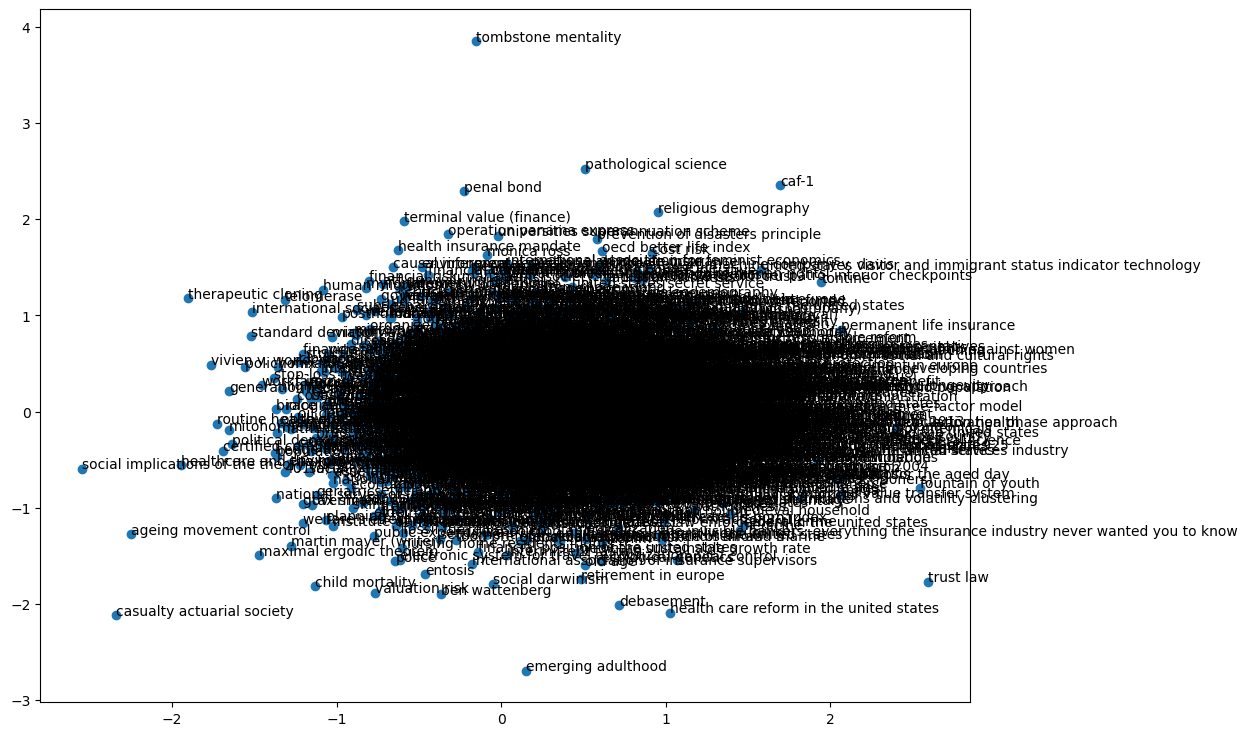

In [48]:
# 可视化

def plot_nodes(node_list):
    X = np.array([embeddings_dict[n] for n in node_list])
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(12,9))
    plt.scatter(result[:,0], result[:,1])
    for i, n in enumerate(node_list):
        plt.annotate(n, xy=(result[i,0], result[i,1]))
    plt.show()

plot_nodes(list(G.nodes()))